# Data augmentation

In [8]:
import os
from tensorflow.keras import preprocessing

# ImageDataGenerator 參數
# width_shift_range=[-3,3], #左右3%
# height_shift_range=[-3,3], #上下3%
# zoom_range=0.3

# input size(w,h)
w = 224
h = 224
# batch size
batchsize=128
# image directory
train_data_dir='./img_ok'
categories = os.listdir(train_data_dir)
datagen = preprocessing.image.ImageDataGenerator(
                             rescale=1. /255,
                             validation_split=0.2,
                             rotation_range=30 ,
                             shear_range=0.3 ,
                             horizontal_flip=True,
                             data_format='channels_last')
train_data = datagen.flow_from_directory(train_data_dir,
                                         target_size = (w,h),
                                         class_mode = 'categorical',
                                         color_mode = 'rgb',
                                         batch_size = batchsize,
                                         shuffle = True,
                                         subset = 'training'
                                         )
validation_data = datagen.flow_from_directory(train_data_dir,
                                         target_size = (w,h),
                                         class_mode = 'categorical',
                                         color_mode = 'rgb',
                                         batch_size = batchsize,
                                         shuffle = True,
                                         subset = 'validation'
                                         )

Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


# 隨意搭個CNN

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# gpu除錯
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

layer_input = Input(shape = (100, 100, 3))
x = layer_input 
x = Conv2D(8, 3, 1, input_shape = (100, 100, 3),padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(16, 3, 1,padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(32, 3, 1,padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(64, 3, 1,padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(128, 3, 1,padding='same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(300,activation='relu')(x)
x = Dense(300,activation='relu')(x)
x = Dense(len(categories),activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)
new_model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0     

# VGG16 Conv & Maxpooling layers + FN

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# gpu除錯
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

layer_input = Input(shape = (224, 224, 3)) # a new input tensor to be able to feed the desired layer

#微調VGG ImageNet
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"


model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))
x = layer_input 
for layer in model.layers[1::1]:
    layer.trainable = False
    x = layer(x)
x = Flatten()(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(len(categories),activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)
new_model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [11]:
from tensorflow.keras import callbacks
with open("wear_cnn_model.json", 'w') as json_file:
    json_file.write(new_model.to_json())
    
checkpoint = callbacks.ModelCheckpoint("wear_cnn_model.h5",
                            monitor='loss', verbose=1, save_best_only=True,
                            mode='auto', period=1)
# from tensorflow.keras import callbacks
# with open("testing_cnn_model.json", 'w') as json_file:
#     json_file.write(new_model.to_json())
    
# checkpoint = callbacks.ModelCheckpoint("testing_cnn_model.h5",
#                             monitor='loss', verbose=1, save_best_only=True,
#                             mode='auto', period=1)

history = new_model.fit_generator(train_data,
                              epochs = 100,
                              verbose = 1,
                              shuffle = True,
                              validation_data = validation_data,
                              callbacks = [checkpoint]) # 每次都呼叫儲存函式

Epoch 1/100
19/19 [==============================] - 28s 1s/step - loss: 15.9455 - accuracy: 0.2827 - val_loss: 7.1674 - val_accuracy: 0.4950

Epoch 00001: loss improved from inf to 12.42567, saving model to wear_cnn_model.h5
Epoch 2/100
19/19 [==============================] - 26s 1s/step - loss: 6.3519 - accuracy: 0.6084 - val_loss: 4.7111 - val_accuracy: 0.6250

Epoch 00002: loss improved from 12.42567 to 5.78189, saving model to wear_cnn_model.h5
Epoch 3/100
19/19 [==============================] - 26s 1s/step - loss: 4.1992 - accuracy: 0.7281 - val_loss: 3.5182 - val_accuracy: 0.6700

Epoch 00003: loss improved from 5.78189 to 3.88761, saving model to wear_cnn_model.h5
Epoch 4/100
19/19 [==============================] - 26s 1s/step - loss: 3.1364 - accuracy: 0.7912 - val_loss: 2.9006 - val_accuracy: 0.7117

Epoch 00004: loss improved from 3.88761 to 2.99589, saving model to wear_cnn_model.h5
Epoch 5/100
19/19 [==============================] - 26s 1s/step - loss: 2.5820 - accurac


Epoch 00037: loss improved from 0.84939 to 0.83747, saving model to wear_cnn_model.h5
Epoch 38/100
19/19 [==============================] - 27s 1s/step - loss: 0.9090 - accuracy: 0.8489 - val_loss: 1.3291 - val_accuracy: 0.7117

Epoch 00038: loss did not improve from 0.83747
Epoch 39/100
19/19 [==============================] - 27s 1s/step - loss: 0.8767 - accuracy: 0.8698 - val_loss: 1.4113 - val_accuracy: 0.6783

Epoch 00039: loss did not improve from 0.83747
Epoch 40/100
19/19 [==============================] - 27s 1s/step - loss: 0.8340 - accuracy: 0.8780 - val_loss: 1.4905 - val_accuracy: 0.6533

Epoch 00040: loss did not improve from 0.83747
Epoch 41/100
19/19 [==============================] - 28s 1s/step - loss: 0.8621 - accuracy: 0.8630 - val_loss: 1.2871 - val_accuracy: 0.7067

Epoch 00041: loss did not improve from 0.83747
Epoch 42/100
19/19 [==============================] - 28s 1s/step - loss: 0.7699 - accuracy: 0.9016 - val_loss: 1.2807 - val_accuracy: 0.6983

Epoch 0004

19/19 [==============================] - 25s 1s/step - loss: 0.5352 - accuracy: 0.9241 - val_loss: 1.0917 - val_accuracy: 0.7233

Epoch 00078: loss improved from 0.56109 to 0.55250, saving model to wear_cnn_model.h5
Epoch 79/100
19/19 [==============================] - 25s 1s/step - loss: 0.5270 - accuracy: 0.9267 - val_loss: 1.3425 - val_accuracy: 0.6650

Epoch 00079: loss improved from 0.55250 to 0.54277, saving model to wear_cnn_model.h5
Epoch 80/100
19/19 [==============================] - 25s 1s/step - loss: 0.5455 - accuracy: 0.9114 - val_loss: 1.1895 - val_accuracy: 0.7200

Epoch 00080: loss did not improve from 0.54277
Epoch 81/100
19/19 [==============================] - 26s 1s/step - loss: 0.5483 - accuracy: 0.9107 - val_loss: 1.3913 - val_accuracy: 0.6717

Epoch 00081: loss did not improve from 0.54277
Epoch 82/100
19/19 [==============================] - 25s 1s/step - loss: 0.6724 - accuracy: 0.8615 - val_loss: 1.1652 - val_accuracy: 0.7250

Epoch 00082: loss did not improv

In [15]:
score = new_model.evaluate_generator(validation_data, workers=1)
print("Loss: ", score[0], "Accuracy: ", score[1])

Loss:  1.1128194332122803 Accuracy:  0.7316666841506958


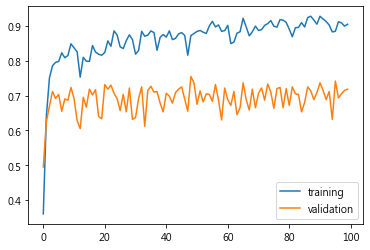

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

測試模型

In [17]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2

def image_cate_predict(path):
    w = 224
    h = 224
    IMAGE_SIZE = (w, h)
    image = cv2.imdecode(np.fromfile(path.replace('\\','/'),dtype=np.uint8),-1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    image = image.reshape(1,w,h,3)
    re_image = image/255
    model = load_model('wear_cnn_model.h5')
    predictions = model.predict(re_image)
    pred_labels = np.argmax(predictions, axis = 1)
    return pred_labels


labels = image_cate_predict('./img_ok_1-500/裙子_ok_1-500/nan_裙子_53588006.jpg')
for i ,cat in enumerate(categories):
    print(i,cat)
print(20*'---')
# for idx,cate in enumerate(categories):
#     if labels[0][idx]==1:
#         print(idx,cate)
for i in labels:
    print(i)

0 Dress
1 Outerwear
2 Overalls
3 Pants
4 Skirt
5 Top
------------------------------------------------------------
4
